In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys; sys.path.append('..')
import glob
import fastai_scans


In [2]:
voxels = (34, 42, 34)

In [3]:
raw_mri_dir, targets_fname = get_IXI_data()
raw_mri_fnames = [f for f in sorted(glob.glob(f'{raw_mri_dir}/*.nii.gz'))]
bcolz_path = fastba.preprocess(raw_mri_fnames, voxels=voxels)

Download demographic data from http://biomedic.doc.ic.ac.uk/brain-development/downloads/IXI/IXI.xls


  0%|          | 0.00/210k [00:00<?, ?iB/s]

FileNotFoundError: [Errno 2] No such file or directory: '../data/IXI.xls'

In [18]:
# Check if files and targets match
fastba.files_ages_mapping(raw_mri_fnames, targets_fname)

,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE,nifti_file_name
IXI_ID,,,,,,,,,,,,
2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.800137,../data/T1/IXI002-Guys-0828-T1.nii.gz
12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.781656,../data/T1/IXI012-HH-1211-T1.nii.gz
13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.710472,../data/T1/IXI013-HH-1212-T1.nii.gz
14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.236824,../data/T1/IXI014-HH-1236-T1.nii.gz
15,1,181,90,2,1,6,5,1981-03-11,1,2005-06-23,24.284736,../data/T1/IXI015-HH-1258-T1.nii.gz
...,...,...,...,...,...,...,...,...,...,...,...,...
648,1,193,120,1,1,6,4,1959-03-08,1,2006-11-27,47.723477,../data/T1/IXI648-Guys-1107-T1.nii.gz
651,1,175,61,3,2,8,2,1956-07-09,1,2006-12-01,50.395619,../data/T1/IXI651-Guys-1118-T1.nii.gz
652,1,163,80,1,1,1,5,1963-12-05,1,2006-12-01,42.989733,../data/T1/IXI652-Guys-1116-T1.nii.gz


In [4]:
# Add column 'age_centuries' which is age * .01. This normalizes the age target while still being interpretable
y = fastba.create_ages_target(targets_fname, 'AGE')
y_fname = f'{os.path.dirname(targets_fname)}/y.csv'
y.to_csv(y_fname)

In [20]:
# Get learner (model & data, wrapped in one object)
learner, data, valid_idxs = fastba.get_learner(bcolz_path, y_fname,
                                               voxels=voxels,
                                               split=.2, #  20% of data is used for validation during training
                                               zoom=1.1, # scans are zoomed by a factor between 1 and 1.1 (random pick)
                                               bs=64)

/home/lukas/miniconda3/envs/fastba/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


/home/lukas/miniconda3/envs/fastba/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


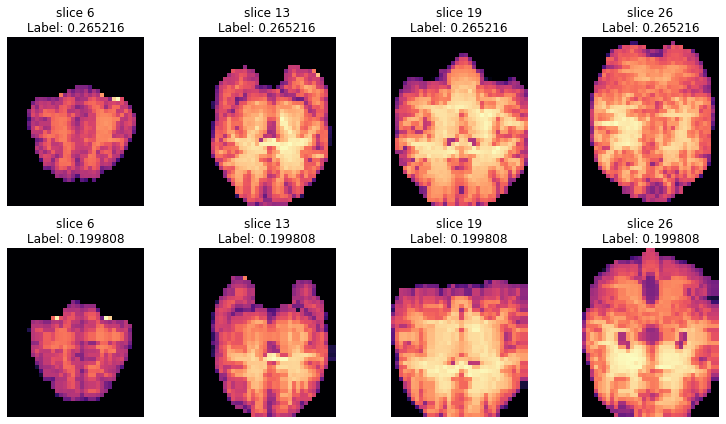

In [7]:
# Show data
data.show_batch(2)

In [21]:
# Train with (optimal) hyperparameters used in paper
start_model = f'pretrained_{voxels[0]}'   # if start_model = None training from scratch
learner = fastba.train(learner);

epoch     train_loss  valid_loss  mean_absolute_error  time    
0         0.070102    0.250637    0.476419             00:00     
1         0.049882    0.097843    0.282847             00:00     
2         0.036973    0.025597    0.133352             00:00     
3         0.029743    0.135419    0.350101             00:00     
4         0.025037    0.206560    0.432840             00:00     
5         0.021850    0.216057    0.445078             00:00     
6         0.019456    0.032518    0.157990             00:00     
7         0.017748    0.054261    0.207708             00:00     
8         0.016498    0.025895    0.135888             00:00     
9         0.015517    0.014693    0.101847             00:00     
10        0.014589    0.174559    0.396989             00:00     
11        0.013935    0.061505    0.227711             00:00     
12        0.013057    0.164068    0.385037             00:00     
13        0.012620    0.014482    0.096660             00:00     
14        0.

/home/lukas/miniconda3/envs/fastba/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


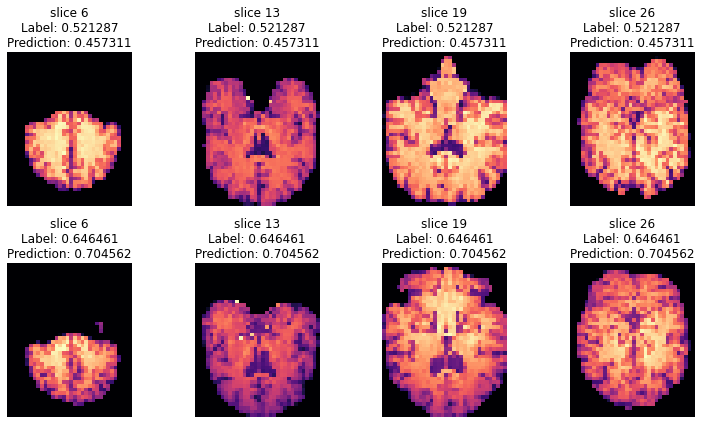

In [9]:
# Show data
learner.show_results(rows=2)

torch.Size([113]) torch.Size([113])


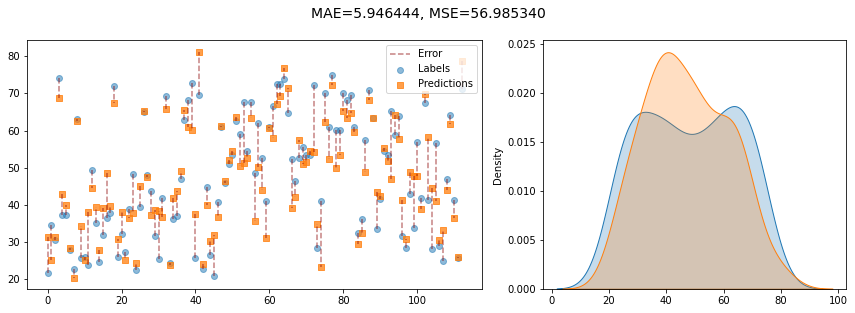

In [25]:
# Evaluate age predicitons using fastai_scans regression report
brain_age = learner.get_preds(ds_type=DatasetType.Valid)[0].reshape(-1) * 100.
age = torch.tensor(data.valid_ds.y.items) * 100.
fastai_scans.regression_report(brain_age, age);

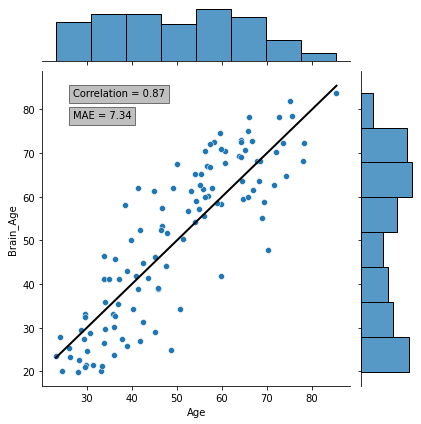

In [51]:
# Evaluate age predicitons using correlation plot
append_to_original_df = True
age_col = 'AGE'
res = fastba.get_valid_results(learner, y_fname, age_col, valid_idxs, append_to_original_df)
fastba.plot_correlation(res, age_col)

In [5]:
# Train model, using 10 fold cross-validation
start_model = f'pretrained_{voxels[0]}'   # if start_model = None training from scratch
metrics, res = fastba.cv(bcolz_path, y_fname, folds=5, age_col='AGE')
print(metrics)

/home/lukas/miniconda3/envs/fastba/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


epoch     train_loss  valid_loss  mean_absolute_error  time    
0         0.075285    0.282258    0.507867             00:01     
1         0.054240    0.257328    0.485955             00:00     
2         0.040004    0.277592    0.503936             00:00     
3         0.032081    0.243524    0.473538             00:00     
4         0.027151    0.160339    0.385333             00:00     
5         0.023728    0.135576    0.351470             00:00     
6         0.021241    0.008315    0.072044             00:00     
7         0.019174    0.021006    0.124821             00:00     
8         0.017445    0.205246    0.435961             00:00     
9         0.016192    0.010697    0.080238             00:00     
10        0.015475    0.073554    0.246079             00:00     
11        0.014794    0.043016    0.180517             00:00     
12        0.014112    0.042694    0.182322             00:00     
13        0.013428    0.098060    0.291752             00:00     
14        0.

In [6]:
print(res)

        SEX_ID (1=m, 2=f)  HEIGHT  WEIGHT  ETHNIC_ID  MARITAL_ID  \
IXI_ID                                                             
2                       2     164      58          1           4   
12                      1     175      70          1           2   
13                      1     182      70          1           2   
14                      2     163      65          1           4   
15                      1     181      90          2           1   
...                   ...     ...     ...        ...         ...   
648                     1     193     120          1           1   
651                     1     175      61          3           2   
652                     1     163      80          1           1   
653                     1     172     100          1           3   
662                     1     182      98          1           4   

        OCCUPATION_ID  QUALIFICATION_ID                  DOB  DATE_AVAILABLE  \
IXI_ID                             

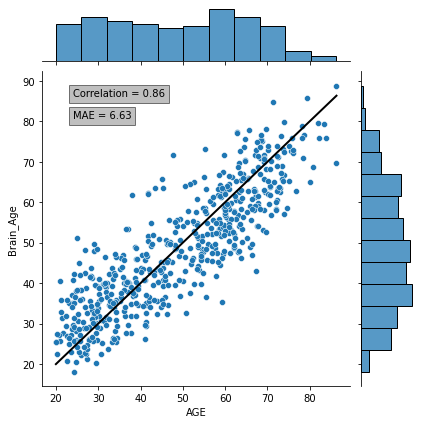

In [7]:
fastba.plot_correlation(res, age_col='AGE');